In [1]:
import numpy as np
import scipy.sparse as sparse
import scipy
import matplotlib.pyplot as plt
import cvxpy as cp
import vectorized_sdr as vect_sdr

np.random.seed(0)

In [2]:
N_omega = 10
N_z = 2
n = 1.7665*10**-5
omega = np.linspace(-3, 3, N_omega)
z = np.linspace(0, 10**-3, N_z)
delta_omega = np.abs(omega[1] - omega[0])
delta_z = np.abs(z[1] - z[0])
green_f = [np.diag(np.exp(1.j*omega*z[i])) for i in range(N_z)]
green_f.reverse()
green_f[0] = 0.5*green_f[0]
green_f[-1] = 0.5*green_f[-1]
beta_up = delta_omega*np.random.random(N_omega)
beta_down = delta_omega*np.random.random(N_omega)
vectorized_beta = np.concatenate((beta_up, beta_down[1:]))
beta = scipy.linalg.hankel(beta_up, beta_down)
delta_k = np.diag(1.j*omega)
Q_plus = delta_k + beta
Q_minus = delta_k - beta
W_plus = [scipy.linalg.expm(Q_plus*z[i]) for i in range(N_z)]
W_minus = [scipy.linalg.expm(Q_minus*z[i]) for i in range(N_z)]
# Try only defining the last J
J = 0.25*(W_plus[-1]@W_plus[-1].conj().T + W_minus[-1]@W_minus[-1].conj().T - 2*np.eye(N_omega))
vectorized_W_plus = sparse.vstack([vect_sdr.mat_to_vec(W_plus[i]) for i in range(N_z)])
vectorized_W_minus = sparse.vstack([vect_sdr.mat_to_vec(W_minus[i]) for i in range(N_z)])
vectorized_J = vect_sdr.mat_to_vec(J)
x = sparse.vstack([vectorized_J, vectorized_W_plus, vectorized_W_minus, sparse.csc_matrix(vectorized_beta).T])
y = sparse.vstack([x, 1])

In [3]:
np.trace(J)**2 - np.trace(J.conj().T@J)

(1.0553229741742374e-10+0j)

In [4]:
semi_def_constr = sparse.eye(1)
semi_def_constr = sparse.bmat([[sparse.csc_matrix(((2*N_z + 1)*(N_omega**2) + 2*N_omega - 1,(2*N_z + 1)*(N_omega**2) + 2*N_omega - 1)), sparse.csc_matrix(((2*N_z + 1)*(N_omega**2) + 2*N_omega - 1,1))],[sparse.csc_matrix((1,(2*N_z + 1)*(N_omega**2) + 2*N_omega - 1)), semi_def_constr]])


In [5]:
projection = np.zeros((N_omega, N_omega))
J_def_constr = []
real_plus_dyn = []
imag_plus_dyn = []
real_minus_dyn = []
imag_minus_dyn = []
plus_verif_list = []
minus_verif_list = []
for i in range(N_omega):
    for j in range(N_omega):
        proj = projection.copy()
        proj[i, j] = 1
        real_plus_mats, imag_plus_mats, real_minus_mats, imag_minus_mats = vect_sdr.dynamics_mat(omega, z, proj)
        plus_verif, minus_verif = vect_sdr.verif_constr(W_plus, W_minus, beta, proj, omega, z)
        J_def_constr.append(vect_sdr.J_def_sdp_mat(N_omega, N_z, proj))
        plus_verif_list += plus_verif
        minus_verif_list += minus_verif
        real_plus_dyn += real_plus_mats
        imag_plus_dyn += imag_plus_mats
        real_minus_dyn += real_minus_mats
        imag_minus_dyn += imag_minus_mats
photon_numb_constr = vect_sdr.photon_numb_mat(N_omega, N_z, n)
constr_mats = J_def_constr + real_plus_dyn + imag_plus_dyn + real_minus_dyn + imag_minus_dyn
constr_mats.append(photon_numb_constr)
constr_mats.append(semi_def_constr)
test_W_plus = [(y.conj().T@real_plus_dyn[i]@y).toarray()[0,0] + 1.j*(y.conj().T@imag_plus_dyn[i]@y).toarray()[0,0] for i in range(len(real_plus_dyn))]
test_W_minus = [(y.conj().T@real_minus_dyn[i]@y).toarray()[0,0] + 1.j*(y.conj().T@imag_minus_dyn[i]@y).toarray()[0,0] for i in range(len(real_plus_dyn))]

In [17]:
len(real_plus_dyn), N_omega**2

(200, 100)

In [6]:
[(y.conj().T@constr_mats[i]@y).toarray()[0,0] for i in range(len(constr_mats)) if np.abs((y.conj().T@constr_mats[i]@y).toarray()[0,0]) > 10**-5]

[(1+0j)]

In [7]:
vec_to_hankel = vect_sdr.omega_vec_to_omega_dof(N_omega)
lin = vect_sdr.vectorized_proj(N_omega, N_z, proj)
dynamics_real_list = [sparse.csc_matrix(((2*N_z + 1)*(N_omega**2) + 2*N_omega - 1, (2*N_z + 1)*(N_omega**2) + 2*N_omega - 1))]
dynamics_imag_list = [sparse.csc_matrix(((2*N_z + 1)*(N_omega**2) + 2*N_omega - 1, (2*N_z + 1)*(N_omega**2) + 2*N_omega - 1))]
for i in range(1, N_z):
    green_fs = vect_sdr.get_green_f(omega, z[:i + 1])
    projected_green_fs = [sparse.csc_matrix(green_fs[i]@proj) for i in range(len(green_fs))]
    full_proj_green_fs = [delta_z*sparse.kron(sparse.eye(N_omega), projected_green_fs[i]) for i in range(len(green_fs))]
    rect_proj_green_fs = [vec_to_hankel.conj().T@full_proj_green_fs[i] for i in range(len(green_fs))]
    rect_proj_green_fs.reverse()
    rect_proj_green_fs[0] = 0.5*rect_proj_green_fs[0]
    rect_proj_green_fs[-1] = 0.5*rect_proj_green_fs[-1]
    # Good until here
    stacked_dynamics = sparse.hstack(rect_proj_green_fs)
    stacked_dynamics.resize((2*N_omega - 1, (2*N_z*(N_omega**2) + 2*N_omega - 1)))
    stacked_dynamics = sparse.hstack([sparse.csc_matrix((2*N_omega - 1, N_omega**2)), stacked_dynamics])
    stacked_dynamics = sparse.vstack([sparse.csc_matrix(((2*N_z + 1)*(N_omega**2), (2*N_z + 1)*(N_omega**2) + 2*N_omega - 1)), stacked_dynamics])
    dynamics_real_list.append(0.5*(stacked_dynamics + stacked_dynamics.conj().T))
    dynamics_imag_list.append(-0.5*1.j*(stacked_dynamics - stacked_dynamics.conj().T))

In [8]:
# covariance of pump
constr_cov = sparse.csc_matrix(np.diag(np.linspace(omega[0], omega[-1], 2*N_omega - 1)))
constr_cov = sparse.bmat([[constr_cov, sparse.csc_matrix((2*N_omega - 1, 1))],[sparse.csc_matrix((1, 2*N_omega - 1)), -0.1*sparse.eye(1)]])
constr_cov.resize((2*N_omega, 2*N_omega))
constr_cov = sparse.bmat([[sparse.csc_matrix(((2*N_z + 1)*(N_omega**2),(2*N_z + 1)*(N_omega**2))), sparse.csc_matrix(((2*N_z + 1)*(N_omega**2), 2*N_omega))],[sparse.csc_matrix((2*N_omega, (2*N_z + 1)*(N_omega**2))), constr_cov]])

In [9]:
vec_to_hankel = vect_sdr.omega_vec_to_omega_dof(N_omega)
plus_dyn_real, plus_dyn_imag = vect_sdr.dynamics_W(omega, z, proj, vec_to_hankel, "plus")
minus_dyn_real, minus_dyn_imag = vect_sdr.dynamics_W(omega, z, proj, vec_to_hankel, "minus")
full_proj_plus = vect_sdr.vectorized_proj(N_omega, N_z, proj)[1:N_z + 1]
full_proj_minus = vect_sdr.vectorized_proj(N_omega, N_z, proj)[N_z + 1:2*N_z + 1]
green_f = vect_sdr.get_green_f(omega, z)
real_plus_mats_test = [sparse.bmat([[plus_dyn_real[i], -0.5*full_proj_plus[i]],[-0.5*full_proj_plus[i].conj().T, np.real(np.trace(proj@green_f[i]))]]) for i in range(N_z)]
imag_plus_mats_test = [sparse.bmat([[plus_dyn_imag[i], -0.5*1.j*full_proj_plus[i]],[0.5*1.j*full_proj_plus[i].conj().T, np.imag(np.trace(proj@green_f[i]))]]) for i in range(N_z)]
real_minus_mats_test = [sparse.bmat([[minus_dyn_real[i], -0.5*full_proj_minus[i]],[-0.5*full_proj_minus[i].conj().T, np.real(np.trace(proj@green_f[i]))]]) for i in range(N_z)]
imag_minus_mats_test = [sparse.bmat([[minus_dyn_imag[i], -0.5*1.j*full_proj_minus[i]],[0.5*1.j*full_proj_minus[i].conj().T, np.imag(np.trace(proj@green_f[i]))]]) for i in range(N_z)]

In [10]:
# Try adding a covariance penalty
X = cp.Variable(shape=((2*N_z + 1)*(N_omega**2) + 2*N_omega,(2*N_z + 1)*(N_omega**2) + 2*N_omega), hermitian = True)
obj_f_mat = vect_sdr.obj_f_sdp_mat(N_omega, N_z, n)
constraints = [X >> 0]
constraints += [cp.real(cp.trace(J_def_constr[i]@X)) == 0 for i in range(len(J_def_constr))]
constraints += [cp.real(cp.trace(real_plus_dyn[i]@X)) == 0 for i in range(len(real_plus_dyn))]
constraints += [cp.real(cp.trace(imag_plus_dyn[i]@X)) == 0 for i in range(len(real_plus_dyn))]
constraints += [cp.real(cp.trace(real_minus_dyn[i]@X)) == 0 for i in range(len(real_plus_dyn))]
constraints += [cp.real(cp.trace(imag_minus_dyn[i]@X)) == 0 for i in range(len(real_plus_dyn))]
constraints.append(cp.real(cp.trace(photon_numb_constr@X)) == 0)
constraints.append(cp.real((cp.trace(semi_def_constr@X))) == 1)
constraints.append(cp.real(cp.trace(obj_f_mat@X)) >= 0.)
constraints.append(cp.real(cp.trace(constr_cov@X))<=0)
problem = cp.Problem(cp.Minimize(cp.real(cp.trace(obj_f_mat@X))), constraints)

In [11]:
problem.solve(solver = "SCS",verbose = True)

                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Feb 09 01:55:25 PM: Your problem has 270400 variables, 905 constraints, and 0 parameters.
(CVXPY) Feb 09 01:55:25 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 09 01:55:25 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Feb 09 01:55:25 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Feb 09 01:55:25 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Feb 09 01:55:25 PM: Compiling problem (target solver=SCS).

9.289820144263434e-10

In [12]:
np_variable = X.value
beta_outer = np_variable[(2*N_z + 1)*(N_omega**2):(2*N_z + 1)*(N_omega**2) + 2*N_omega - 1, (2*N_z + 1)*(N_omega**2):(2*N_z + 1)*(N_omega**2) + 2*N_omega - 1]

In [13]:
test_beta = np_variable[-1, 5*(N_omega**2):5*(N_omega**2) + 2*N_omega - 1]
hankel_test = scipy.linalg.hankel(test_beta[:N_omega], test_beta[N_omega - 1:])

In [14]:
test_beta

array([ 1.37570080e-15-2.20363613e-15j,  3.52848183e-16-1.37603527e-15j,
       -7.51071810e-16+4.67307271e-16j,  3.85195053e-15-1.82207668e-15j,
        7.89232527e-16+1.04850518e-16j, -2.39584952e-15+1.84329255e-15j,
       -9.27434960e-15+2.56565379e-15j, -4.53643833e-15+7.24337864e-15j,
       -4.97562344e-15-5.45919775e-15j,  5.70845610e-15-6.10280360e-15j,
       -2.02972480e-14-8.55455200e-15j,  8.76447006e-15-4.87718914e-16j,
       -6.04717314e-15-4.54783722e-15j, -8.64009516e-15+2.22365083e-15j,
        1.40537894e-15-7.20251466e-15j, -5.04289091e-15-1.02149721e-14j,
        2.09602673e-15+3.33625916e-15j, -3.26795113e-15+1.40985037e-15j,
        1.69265697e-15-2.94390695e-16j])

In [40]:
W_minus_test = (vect_sdr.vec_to_mat(np_variable[-1, 4*(N_omega**2):5*(N_omega**2)]))
W_plus_test = (vect_sdr.vec_to_mat(np_variable[-1, 2*(N_omega**2):3*(N_omega**2)]))

/home/jiaqizhao/Downloads/cvxpy_qcqp/vectorized_sdr.py:14: ComplexWarning: Casting complex values to real discards the imaginary part
  mat[i] = vect[i*mat_dim:(i + 1)*mat_dim]


In [41]:
vecteur = np_variable[-1, 4*(N_omega**2):5*(N_omega**2)]
mat_dim = int(np.sqrt(len(vecteur)))
mat_min = np.zeros((mat_dim, mat_dim)).astype("complex128")
for i in range(len(mat_min)):
    mat_min[i] = vecteur[i*mat_dim:(i + 1)*mat_dim]
vecteur = np_variable[-1, 2*(N_omega**2):3*(N_omega**2)]
mat_dim = int(np.sqrt(len(vecteur)))
mat_plus = np.zeros((mat_dim, mat_dim)).astype("complex128")
for i in range(len(mat_min)):
    mat_plus[i] = vecteur[i*mat_dim:(i + 1)*mat_dim]

In [13]:
test_W_plus = scipy.linalg.expm((1.j*np.diag(omega) + hankel_test)*z[-1])
test_W_minus = scipy.linalg.expm((1.j*np.diag(omega) + hankel_test)*z[-1])
J = 0.25*(test_W_plus@test_W_plus.conj().T + test_W_minus@test_W_minus.conj().T - 2*np.eye(N_omega))

In [14]:
np.trace(J.conj().T@J)

(6.44831490606725e-33+0j)

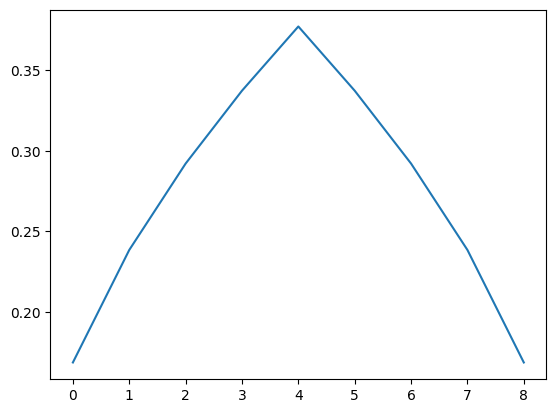

In [38]:
plt.plot(np.diag(np.real(beta_outer)))

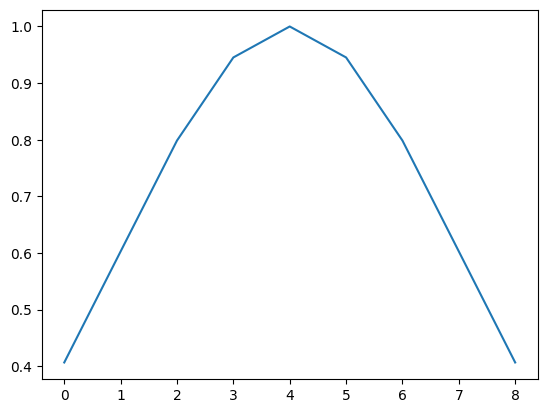

In [28]:
gauss = np.exp(-(np.linspace(-3, 3, 2*N_omega - 1)**2)/10)
plt.plot(gauss)

In [50]:
random_values = np.random.random(3)
circ = scipy.linalg.circulant(random_values)
anti_circ = random_values[0]*np.eye(3) + random_values[1]*np.array([[0., 1., 0.],[0., 0., 1.],[-1., 0., 0.]]) + random_values[2]*np.array([[0., 0., 1.],[-1., 0., 0.],[0., -1., 0.]])

In [63]:
eig_val, eig_vec = scipy.linalg.eig(circ)
#eig_val, eig_vec = scipy.linalg.eig(anti_circ)


In [64]:
np.abs(eig_vec)**2

array([[0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333]])

In [52]:
circ, anti_circ

(array([[0.0187898 , 0.61209572, 0.6176355 ],
        [0.6176355 , 0.0187898 , 0.61209572],
        [0.61209572, 0.6176355 , 0.0187898 ]]),
 array([[ 0.0187898 ,  0.6176355 ,  0.61209572],
        [-0.61209572,  0.0187898 ,  0.6176355 ],
        [-0.6176355 , -0.61209572,  0.0187898 ]]))